In [1]:
import os
import sys
sys.path.append('../')
from utils import load_walksheds, overlay_wks, reformat
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from shapely.geometry import Point
import pandas as pd

### Bike travel time

In [2]:
dtype_spec = {'start_station_id':'str','end_station_id':'str'}
## bike data
bikedata = pd.concat([
    pd.read_excel('../../Data/Bike share/202204-capitalbikeshare-tripdata/202204-capitalbikeshare-tripdata.xlsx', dtype=dtype_spec),
    pd.read_excel('../../Data/Bike share/202205-capitalbikeshare-tripdata/202205-capitalbikeshare-tripdata.xlsx', dtype=dtype_spec)
])

In [3]:
rename_dict = {
    'start_station_id':'bike_station_id',
    'start_lat':'lat',
    'start_lng':'lng',
    'end_station_id':'bike_station_id',
    'end_lat':'lat',
    'end_lng':'lng',
}

In [4]:
bike_locations = pd.concat([
    bikedata[['start_station_id','start_lat','start_lng']].rename(rename_dict,axis=1),
    bikedata[['end_station_id','end_lat','end_lng']].rename(rename_dict,axis=1)
]).drop_duplicates('bike_station_id')

In [5]:
bike_locations = gpd.GeoDataFrame(bike_locations,
                                  geometry=gpd.points_from_xy(bike_locations.lng,bike_locations.lat),
                                  crs="EPSG:4326"
                                 )

<Axes: >

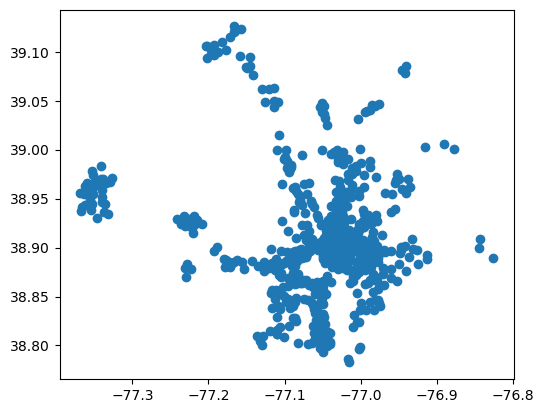

In [6]:
bike_locations.plot()

* load in the walksheds at 0.5 and 0.75 for the urban/surburban split

In [7]:
wksp5, wksp75 = load_walksheds()

In [8]:
intp5, intp75 = overlay_wks(bike_locations)

In [9]:
intp5, int75 = intp5[['Name_1','bike_station_id']], intp75[['Name_1','bike_station_id']]

In [10]:
bikedata['trip_minutes'] = (bikedata['ended_at'] - bikedata['started_at'])/ pd.Timedelta(minutes=1)

In [11]:
bikedata_weekday = bikedata[bikedata['started_at'].dt.day_name().isin(['Monday','Tuesday','Wednesday','Thursday','Friday'])]

In [12]:
# for 0.5m

bike_traveltime_p5 = bikedata_weekday.query('trip_minutes < 1440 & start_station_id != end_station_id').dropna()\
.merge(intp5.rename({'Name_1':'name_O','MSTN':'MSTN_O'},axis=1),
          left_on='start_station_id',right_on='bike_station_id')\
.merge(intp5.rename({'Name_1':'name_D','MSTN':'MSTN_D'},axis=1),
          left_on='end_station_id',right_on='bike_station_id')

In [13]:
# for 0.75m

bike_traveltime_p75 = bikedata_weekday.query('trip_minutes < 1440 & start_station_id != end_station_id').dropna()\
.merge(int75.rename({'Name_1':'name_O','MSTN':'MSTN_O'},axis=1),
          left_on='start_station_id',right_on='bike_station_id')\
.merge(int75.rename({'Name_1':'name_D','MSTN':'MSTN_D'},axis=1),
          left_on='end_station_id',right_on='bike_station_id')

In [14]:
btt_p5 = bike_traveltime_p5.groupby(['name_O','name_D']).agg({'trip_minutes':['median','count']})
btt_p75 = bike_traveltime_p75.groupby(['name_O','name_D']).agg({'trip_minutes':['median','count']})

In [15]:
btt_p5 = btt_p5.reset_index().set_axis(['name_O', 'name_D', 'median', 'count'], axis=1).query('count>2 & name_O!=name_D')
btt_p75 = btt_p75.reset_index().set_axis(['name_O', 'name_D', 'median', 'count'], axis=1).query('count>2 & name_O!=name_D')

In [19]:
import os
os.makedirs('output', exist_ok=True)
btt_p5.rename(columns={'median':'median_p5'}).to_csv('output/bike_tt_p5.csv', index=False)
btt_p75.rename(columns={'median':'median_p75'}).to_csv('output/bike_tt_p75.csv', index=False)